In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import numba as nb
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats import multitest as mlt
%matplotlib inline

Датасет АБ теста, проведенный на пользователях Яндекса. 
* подтвердим или опровергнем наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
* определим характер этих изменений и практическую значимость вводимого изменения
* определим, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

In [2]:
df = pd.read_csv('ab_browser_test.csv')
df.head(5)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Описание данных:

* userID: уникальный идентификатор пользователя 
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика



Основная метрика — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

In [3]:
#насколько в группе exp больше пользовательских кликов по сравнению с группой control
#в процентах от числа кликов в контрольной группе.
np.abs(100 - 100 * np.sum(df[df['slot']=='exp']['n_clicks'].values) / np.sum(df[df['slot']=='control']['n_clicks'].values))

1.6135689824415778

Сравним доверительные интервалы медиан и средних для двух групп

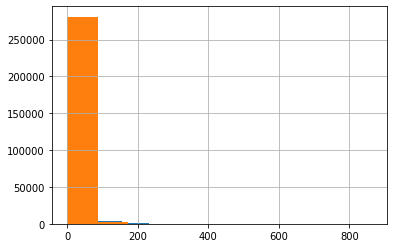

In [4]:
#Распределение данных
df[df['slot']=='exp']['n_clicks'].hist()
df[df['slot']=='control']['n_clicks'].hist()


Распределения явно отличны от нормального, для построения доверительного интервала воспользуемся методом бутстрапа

In [4]:
#функции для бустрапа
@nb.jit(parallel=True)#обернем декаратором для ускорения расчета
def get_bootstrap_samples(data, n_samples):#генерация выборок
    #случайные индексы для извлечения даннных
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    #генерация подвыборки
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):#построение интервалов
    #верхняя и нижняя границы 95% доверительного интервала
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [5]:
#клики в экспериментальной группе
exp_clicks = df[df['slot']=='exp']['n_clicks'].values
#клики в контрольной группе
control_clicks = df[df['slot']=='control']['n_clicks'].values

In [7]:
np.random.seed(0)
#Сгенерируем 1000 подвыборок из выборки и оценим интервально медиану
exp_clicks_median = list(map(np.median, get_bootstrap_samples(exp_clicks, 1000)))
control_clicks_median = list(map(np.median, get_bootstrap_samples(control_clicks, 1000)))

print("95% интервал медиан для экспериментальной группы:",  stat_intervals(exp_clicks_median, 0.05))
print("95% интервал медиан для тестовой группы:",  stat_intervals(control_clicks_median, 0.05))

95% интервал медиан для экспериментальной группы: [5. 5.]
95% интервал медиан для тестовой группы: [4. 4.]


In [8]:
np.random.seed(0)
#Сгенерируем 1000 подвыборок из выборки и оценим интервально среднее
exp_clicks_mean = list(map(np.mean, get_bootstrap_samples(exp_clicks, 1000)))
control_clicks_mean = list(map(np.mean, get_bootstrap_samples(control_clicks, 1000)))

print("95% интервал средних для экспериментальной группы:",  stat_intervals(exp_clicks_mean, 0.05))
print("95% интервал средних для тестовой группы:",  stat_intervals(control_clicks_mean, 0.05))

95% интервал средних для экспериментальной группы: [11.5086867  11.66089388]
95% интервал средних для тестовой группы: [11.20795095 11.35742732]


Сравним разности медиан и средних. Если они не содержат ноль, то средние и медианы отличаются статистически значимо.

In [21]:
#Разность медиан
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_clicks_median, control_clicks_median)))
#Разность средних
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(exp_clicks_mean, control_clicks_mean)))

In [22]:
print("95% интервал разности медиан",  stat_intervals(delta_median_scores, 0.05))
print("95% интервал разности средних",  stat_intervals(delta_mean_scores, 0.05))

95% интервал разности медиан [-1. -1.]
95% интервал разности средних [-0.40475697 -0.19172563]


Интервал разности средних и медиан не содержит 0. Отличия в данных выборочных статистиках статистически значимо. Число кликов в экспериментальной группе действительно больше, чем в тестовой

In [121]:
#Проверим гипотезу о равенстве распределений кликов в двух группа с помощью критерия Манна-Уитни
#Поскольку в выборке есть юзеры, которые заходили из разных браузеров, то необходимо их собрать в один массив и сложить
#количество кликов, после этого построить распределения

#Объединим массивы по номеру пользователя, сложим клики
df2 = df.groupby(['userID']).agg({'n_clicks' : 'sum',
                           'slot' : 'first'})
print(df2[df2['slot']=='control'].shape,df2[df2['slot']=='exp'].shape)

(284392, 2) (281450, 2)


Будем проверять нулевую гипотезу о том, что распределения кликов контрольной и тестовой группой равны, против альтернативы, что они не равны. Поскольку выборки независимы, критерий Манна-Уитни можно использовать. Примем уровень доверия 0,05

In [81]:
stats.mannwhitneyu(df2[df2['slot']=='control']['n_clicks'], df2[df2['slot']=='exp']['n_clicks'])[1]

4.3471471887604393e-75

Таким образом, получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками

In [71]:
np.unique(df['browser'], return_counts=True)

(array(['Browser #14', 'Browser #17', 'Browser #2', 'Browser #20',
        'Browser #22', 'Browser #4'], dtype=object),
 array([ 89123,  32607, 110737,  33929, 142905, 156833], dtype=int64))

Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах. Для Каждого браузера посчитаем критерий Манна-Уитни между контрольной и тестовыми группами, поскольку имеем несколько проверок гипотез используем поправку Холма-Бонферонни

In [86]:
#Получим список браузеров
browsers = np.unique(df['browser'], return_counts=True)[0]
browsers

array(['Browser #14', 'Browser #17', 'Browser #2', 'Browser #20',
       'Browser #22', 'Browser #4'], dtype=object)

In [109]:
#контейнер для хранения
p_values = []
#для каждого браузера
for browser in browsers:
    #формируем группу контроля
    control = df[(df['browser']==browser) & (df['slot']=='control')]['n_clicks']
    #формируем группу теста
    exp = df[(df['browser']==browser) & (df['slot']=='exp')]['n_clicks']
    #считаем p-value
    p_values.append(stats.mannwhitneyu(control, exp)[1])
    
#подаем значения на вход функции множественной проверки гипотез
rejected, p_corrected, a1, a2 = mlt.multipletests(p_values, alpha=0.05, method='holm')

In [110]:
print(rejected, p_corrected)

[ True False False False False False] [0.         0.14960241 0.1362193  0.81521235 0.77221655 0.81521235]


По результатам сравнения распределения кликов в зависимости от браузера на контрольной и тестовой группах согласно критерию Манна-Уитни в совокупности с множественной проверкой гипотез можно установить, что только для браузера "Browser #14" различия в кликах статистически значимо.

Посмотрим на число некликнутых запросов, посчитаем их долю для каждого браузера и группы

In [182]:
#сгруппируем по браузеру контрольную группу
df_control = df[df['slot']=='control'].groupby(['browser']).agg({'n_nonclk_queries' : 'sum', 'n_queries': 'sum'})
#сгруппируем по браузеру тестовую группу
df_exp = df[df['slot']=='exp'].groupby(['browser']).agg({'n_nonclk_queries' : 'sum', 'n_queries': 'sum'})

In [183]:
#доля некликнут запросов в контрольной группе по каждому браузеру
df_control['nonclick_proportion'] = df_control['n_nonclk_queries'] / df_control['n_queries'] * 100
df_control

,n_nonclk_queries,n_queries,nonclick_proportion
browser,,,
Browser #14,161252,279998,57.590411
Browser #17,75837,208921,36.299367
Browser #2,260259,566239,45.962747
Browser #20,78548,193752,40.540485
Browser #22,315470,777135,40.593977
Browser #4,498254,1060771,46.970930


In [184]:
#доля некликнут запросов в тестовой группе по каждому браузеру
df_exp['nonclick_proportion'] = df_exp['n_nonclk_queries'] / df_exp['n_queries'] * 100
df_exp

,n_nonclk_queries,n_queries,nonclick_proportion
browser,,,
Browser #14,123656,282606,43.755617
Browser #17,77614,210123,36.937413
Browser #2,246514,548019,44.982747
Browser #20,72998,187283,38.977376
Browser #22,296177,743156,39.853947
Browser #4,456508,1011250,45.142942


С помощью анализа мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.
Это установлено как формально (с помощью статистических критериев, так и визуально с помощью сранения таблиц)